In [95]:
import quandl
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import json
import datetime as dt
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind


## Data Gathering: Quandl API

In [4]:
# Federal Debt: Total Public Debt as Percent of Gross Domestic Product, Quarterly
# Units: Percent of GDP, Seasonally Adjusted
# Source: FRED (Federal Reserve Bank St. Louis)

debt = quandl.get("FRED/GFDEGDQ188S", authtoken="ckJvd5G2a2dkK9nun3xS")

In [10]:
# S&P 500 Index Composite, Monthly
# Units: Index
# Source: Yale University, Online Data Robert Shiller

sp = quandl.get("YALE/SPCOMP", authtoken="ckJvd5G2a2dkK9nun3xS")

In [60]:
# Unemployment Rate, Monthly
# Units: Percent, Seasonally Adjusted
# Source: FRED (Federal Reserve Bank St. Louis)

u = quandl.get("FRED/UNRATENSA", authtoken="ckJvd5G2a2dkK9nun3xS")

In [7]:
# Balance on Current Account, NIPA's, Quarterly
# Units: Billions of Dollars Seasonally Adjusted Annual Rate
# Source: FRED (Federal Reserve Bank St. Louis)

balance = quandl.get("FRED/NETFI", authtoken="ckJvd5G2a2dkK9nun3xS")

In [8]:
# US Presidents 
presidents = pd.read_csv('us_presidents.csv')
presidents = pd.DataFrame(presidents)

## Data Cleaning: 

### S&P 500 Monthly Returns

In [11]:
# Get the date in a new column to be able to merge tables on Date
sp['Date'] = sp.index

# Adding a new column with t-1 (lag) values to calculate monthly returns on S&P
sp['lag'] = sp['S&P Composite'].shift(1)
                                      
# As there is no lagged S&P for the first date we delete the first row
to_drop = sp.iloc[:1]

sp.drop(to_drop.index, axis=0, inplace=True)
                                      
# The S&P monthly returns is simply the rate of change between months ((t - t-1)/t-1)*100
sp['monthly_return_per'] = ((sp['S&P Composite']-sp['lag'])/sp['lag'])*100

### US Goverment Debt as Percentage of GDP

Taking 1st difference (t - t-1)

In [113]:
debt['Date'] = debt.index
debt['lag'] = debt.Value.shift(1)
to_drop = debt.iloc[:1]
debt.drop(to_drop.index, axis=0, inplace=True)

In [121]:
debt['diff'] = debt['Value'] - debt['lag']

debt.head()

,Value,Date,lag,diff
Date,,,,
1966-07-01,39.62091,1966-07-01,39.26763,0.35328
1966-10-01,39.51977,1966-10-01,39.62091,-0.10114
1967-01-01,39.20383,1967-01-01,39.51977,-0.31594
1967-04-01,38.03292,1967-04-01,39.20383,-1.17091
1967-07-01,38.82145,1967-07-01,38.03292,0.78853


### US Unemployment Rate

Taking 1st difference (t - t-1)

In [141]:
u['Date'] = u.index
u['lag'] = u.Value.shift(1)
to_drop = u.iloc[:1]
u.drop(to_drop.index, axis=0, inplace=True)

In [142]:
u['diff'] = u['Value'] - u['lag']

u.head()

,Value,Date,lag,diff
Date,,,,
1948-02-01,4.7,1948-02-01,4.0,0.7
1948-03-01,4.5,1948-03-01,4.7,-0.2
1948-04-01,4.0,1948-04-01,4.5,-0.5
1948-05-01,3.4,1948-05-01,4.0,-0.6
1948-06-01,3.9,1948-06-01,3.4,0.5


### Merging Presidents data to S&P data

In [36]:
date_start_series = list(presidents['start'])

In [37]:
#Adding missing end date for Obama and using today's data for Trump as he is still in Office

date_end_series[-2] = 'January 20, 2017'
date_end_series[-1] = 'November 12, 2019'

In [57]:
# Converting presidents final dates in office into a datetime object

new_date_end_series = []
for row in date_end_series:
    date = dt.datetime.strptime(row,'%B %d, %Y').strftime('%Y-%m-%d')
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    new_date_end_series.append(datetime_object)

In [39]:
presidents['end_date'] = new_date_end_series
new_president_df = presidents[['president', 'end_date']].copy()

In [40]:
# Deleting presidents before S&P Index start date

to_drop  = new_president_df[:17].index
new_president_df = new_president_df.drop(to_drop, axis = 0)

In [41]:
# Indexing each dataframe by year/month

presidents['month'] = presidents['end_date'].dt.month
presidents['year'] = presidents['end_date'].dt.year
presidents['monthyear'] = presidents['year'].map(str) + '/' + presidents['month'].map(str)

sp['month'] = sp['Date'].dt.month
sp['year'] = sp['Date'].dt.year
sp['monthyear'] = sp['year'].map(str) + '/' + sp['month'].map(str)

In [42]:
# new dataframe, merged from old dataframes on date

df = sp.merge( presidents, on='monthyear', how='left')

# Selecting only columns we want

new_df = df[['Date','monthly_return_per', 'president']]

# filling in all presidents 

new_df['president'] = new_df['president'].fillna(method='backfill')

# filling in Donald trump (as there was no endate)

new_df.president.fillna('Donald Trump', inplace = True)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [108]:
new_df.to_csv('clean_sp.csv')

In [43]:
new_df.tail()

,Date,monthly_return_per,president
1778,2019-04-30,3.559940,Donald Trump
1779,2019-05-31,-1.690543,Donald Trump
1780,2019-06-30,1.242158,Donald Trump
1781,2019-07-31,3.665528,Donald Trump
1782,2019-08-31,-3.742519,Donald Trump


### Sampling: Trump Dummy Variable

In [ ]:
my_list = []

## Data Visualization

### Time Series

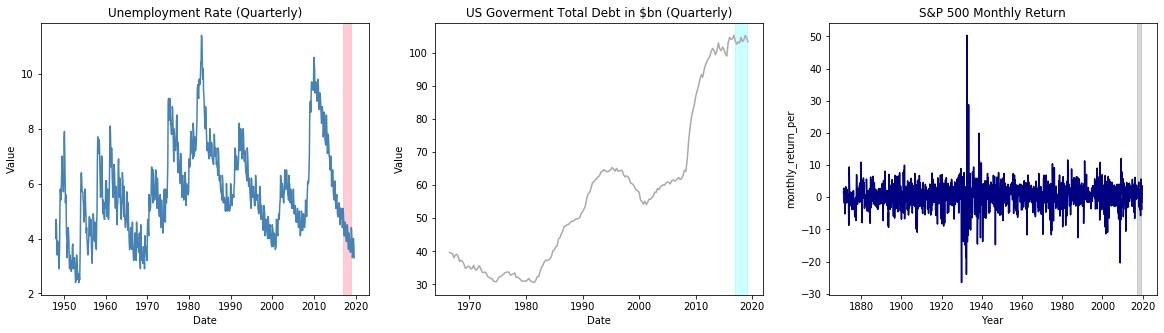

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

sns.lineplot(x= u.index, y=u.Value, ax=ax1, color='steelblue').set_title('Unemployment Rate (Quarterly)')
ax1.axvspan('2017', '2019', alpha=0.8, color='pink')
sns.lineplot(x=debt.index, y=debt.Value, ax=ax2, color='darkgray').set_title('US Goverment Total Debt in $bn (Quarterly)')
ax2.axvspan('2017', '2019', alpha=0.2, color='cyan')
sns.lineplot(x= sp.index, y=sp['monthly_return_per'], ax=ax3, color='navy').set_title('S&P 500 Monthly Return')
ax3.axvspan('2017', '2019', alpha=0.3, color='grey')

plt.show()

### Distribution

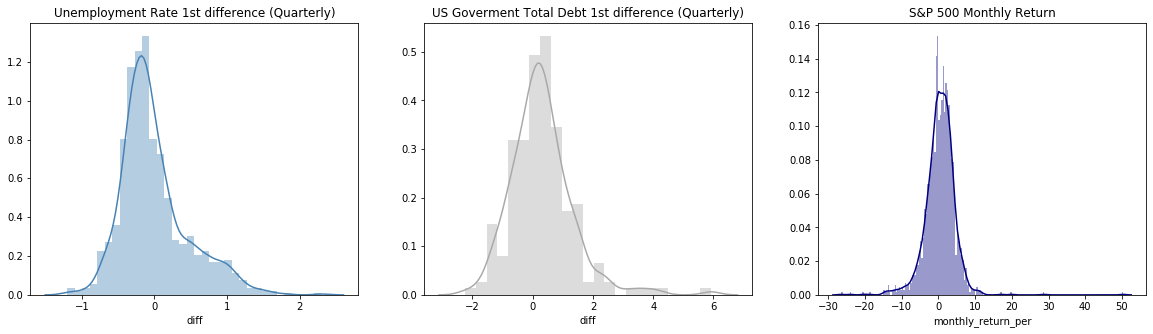

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5)) 

sns.distplot(u['diff'], ax=ax1, color='steelblue').set_title('Unemployment Rate 1st difference (Quarterly)')
sns.distplot(debt['diff'], ax=ax2, color= 'darkgray').set_title('US Goverment Total Debt 1st difference (Quarterly)')
sns.distplot(sp['monthly_return_per'], ax=ax3, bins=200, color='navy').set_title('S&P 500 Monthly Return')

plt.show()

## Hypothesis Testing: T-Test

### Hypothesis 1:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The S&amp;P just hit an ALL TIME HIGH. This is a big win for jobs, 401-K’s, and, frankly, EVERYONE! Our Country is doing great. Even killed long sought ISIS murderer, Al-Baghdadi. We are stronger than ever before, with GREAT upward potential. Enjoy!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/1188813055108374533?ref_src=twsrc%5Etfw">October 28, 2019</a></blockquote>


 
    h0 = Trump has no effect on the rate of growth of the s&p 500
    h1 = Trump is increasing the rate of growth of the s&p 500
    


In [ ]:
# Trump dummy variable



### Hypothesis_2:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Breaking News: Unemployment Rate, at 3.5%, drops to a 50 YEAR LOW. Wow America, lets impeach your President (even though he did nothing wrong!).</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/1180102056411095042?ref_src=twsrc%5Etfw">October 4, 2019</a></blockquote>



    h0 = Trump has no effect on the rate of unemployment in the usa
    h1 = Trump has reduced the rate of unemployment in the USA



### Hypothesis_3: 

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The media has not reported that the National Debt in my first month went down by $12 billion vs a $200 billion increase in Obama first mo.</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/835479283699224576?ref_src=twsrc%5Etfw">February 25, 2017</a></blockquote>



    h0 = Trump has no effect on the level of debt in the USA
    h1 = Trump had reduced the level of national debt in the USA
    
   



In [92]:
# Population mean (μ)
debt.Value.mean()

# Sample mean (x̄) using NumPy mean()


# trump_mean = trump.mean()

57.37872313084113

### Hypothesis_4: 

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The trade deficit rose to a 7yr high thanks to horrible trade policies Clinton supports. I will fix it fast- JOBS! <a href="https://t.co/jaGeN4u50U">https://t.co/jaGeN4u50U</a></p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/743486962670141440?ref_src=twsrc%5Etfw">June 16, 2016</a></blockquote>


    h0 = Trump has no effect on the trade balance of the USA
    h1 = Trump is reducing the trade balance of the USA
